# ITI - Data Analytics Track 
### Final Data Analysis & Regression Project
#### Flight Price Prediction
>* Supervisor: Eng.Amr
>* By: Eng.Hossam Saad
>* [LinkedIn](https://www.linkedin.com/in/hossam-saad-396108172/)

### Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
# plt.style.use('seaborn') #ggplot
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

### Data Cleansing

In [2]:
data = pd.read_excel('Data_Train_Airline_Tickets.xlsx',
                     converters= {'Date_of_Journey': pd.to_datetime,'Dep_Time':pd.to_datetime,
                                  'Arrival_Time':pd.to_datetime})
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2022-06-30 22:20:00,2022-03-22 01:10:00,2h 50m,non-stop,No info,3897
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2022-06-30 05:50:00,2022-06-30 13:15:00,7h 25m,2 stops,No info,7662
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2022-06-30 09:25:00,2022-06-10 04:25:00,19h,2 stops,No info,13882
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,2022-06-30 18:05:00,2022-06-30 23:30:00,5h 25m,1 stop,No info,6218
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,2022-06-30 16:50:00,2022-06-30 21:35:00,4h 45m,1 stop,No info,13302


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Airline          10683 non-null  object        
 1   Date_of_Journey  10683 non-null  datetime64[ns]
 2   Source           10683 non-null  object        
 3   Destination      10683 non-null  object        
 4   Route            10682 non-null  object        
 5   Dep_Time         10683 non-null  datetime64[ns]
 6   Arrival_Time     10683 non-null  datetime64[ns]
 7   Duration         10683 non-null  object        
 8   Total_Stops      10682 non-null  object        
 9   Additional_Info  10683 non-null  object        
 10  Price            10683 non-null  int64         
dtypes: datetime64[ns](3), int64(1), object(7)
memory usage: 918.2+ KB


In [4]:
data.duplicated().sum()

220

In [5]:
data = data.drop_duplicates()

(array([5.993e+03, 4.207e+03, 1.810e+02, 6.600e+01, 7.000e+00, 1.000e+00,
        5.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1759. ,  9534.3, 17309.6, 25084.9, 32860.2, 40635.5, 48410.8,
        56186.1, 63961.4, 71736.7, 79512. ]),
 <BarContainer object of 10 artists>)

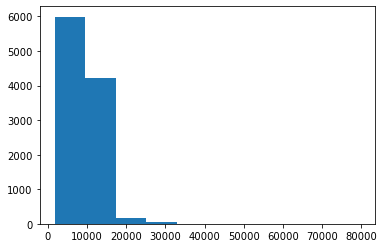

In [6]:
plt.hist(data['Price'])

In [7]:
#Check For Null Values
total_missing = data.isnull().sum().sort_values(ascending= False)
missing_percent = round((data.isnull().sum()/data.isnull().count()) * 100,3).sort_values(ascending= False)
missing = pd.concat([total_missing,missing_percent], axis = 1, keys=['Total','Percent %'])
missing[missing['Total']>0]

,Total,Percent %
Route,1,0.01
Total_Stops,1,0.01


In [8]:
data[data['Route'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,2019-06-05,Delhi,Cochin,NaN,2022-06-30 09:45:00,2022-05-07 09:25:00,23h 40m,NaN,No info,7480


In [9]:
data.dropna(inplace=True)

### Exploratory Data Alysis

In [10]:
# Dsicover Duration Column
data['Duration'].value_counts().to_frame()

,Duration
2h 50m,544
1h 30m,386
2h 45m,335
2h 55m,332
2h 35m,329
...,...
30h 25m,1
30h 15m,1
42h 5m,1
28h 55m,1


In [11]:
# Split Date Columns into Some Columns with Useful Info to dealing with it
data['Jrn_day']=data['Date_of_Journey'].dt.day
data['Jrn_month']=data['Date_of_Journey'].dt.month
data['Jrn_year']=data['Date_of_Journey'].dt.year
data['Dep_hr']=data['Dep_Time'].dt.hour
data['Dep_min']=data['Dep_Time'].dt.minute
data['Arv_hr']=data['Arrival_Time'].dt.hour
data['Arv_min']=data['Arrival_Time'].dt.minute

In [12]:
# Split Duration Column into Hours and munutes
data['Dur_hr'] = data['Duration'].str.extract('(\d+)h', expand=False).astype(float)
data['Dur_hr'] = data['Dur_hr'].fillna(0)
data['Dur_min']= data['Duration'].str.extract('(\d+)m', expand=False).astype(float)
data['Dur_min']= data['Dur_min'].fillna(0)
data.drop(['Duration'],axis=1,inplace=True)

In [13]:
#Drop Unneeded
data.drop(['Date_of_Journey','Dep_Time','Arrival_Time'],axis=1,inplace=True)
data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Jrn_day,Jrn_month,Jrn_year,Dep_hr,Dep_min,Arv_hr,Arv_min,Dur_hr,Dur_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,2019,22,20,1,10,2.0,50.0
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,5,1,2019,5,50,13,15,7.0,25.0
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,6,9,2019,9,25,4,25,19.0,0.0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,5,12,2019,18,5,23,30,5.0,25.0
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,3,1,2019,16,50,21,35,4.0,45.0


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10462 entries, 0 to 10682
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          10462 non-null  object 
 1   Source           10462 non-null  object 
 2   Destination      10462 non-null  object 
 3   Route            10462 non-null  object 
 4   Total_Stops      10462 non-null  object 
 5   Additional_Info  10462 non-null  object 
 6   Price            10462 non-null  int64  
 7   Jrn_day          10462 non-null  int64  
 8   Jrn_month        10462 non-null  int64  
 9   Jrn_year         10462 non-null  int64  
 10  Dep_hr           10462 non-null  int64  
 11  Dep_min          10462 non-null  int64  
 12  Arv_hr           10462 non-null  int64  
 13  Arv_min          10462 non-null  int64  
 14  Dur_hr           10462 non-null  float64
 15  Dur_min          10462 non-null  float64
dtypes: float64(2), int64(8), object(6)
memory usage: 1.4+ MB


In [15]:
# Get Object and Numeric Columns
Categories =data.columns[data.dtypes=='object']
Continuous =data.columns[data.dtypes!='object']
print('Category Features: \n\n   {0} \n\n{2} \n\nContinuous Features: \n\n   {1}'.format(Categories,Continuous,'-'*100))

Category Features: 

   Index(['Airline', 'Source', 'Destination', 'Route', 'Total_Stops',
       'Additional_Info'],
      dtype='object') 

---------------------------------------------------------------------------------------------------- 

Continuous Features: 

   Index(['Price', 'Jrn_day', 'Jrn_month', 'Jrn_year', 'Dep_hr', 'Dep_min',
       'Arv_hr', 'Arv_min', 'Dur_hr', 'Dur_min'],
      dtype='object')


In [16]:
# Display Count of each category for each Object Columns
for col in Categories:
    Catg_value=data[col].value_counts()
    print(col,'Values\n')
    print('{}\n{} \n'.format(Catg_value,'-'*50))

Airline Values

Jet Airways                          3700
IndiGo                               2043
Air India                            1694
Multiple carriers                    1196
SpiceJet                              815
Vistara                               478
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64
-------------------------------------------------- 

Source Values

Delhi       4345
Kolkata     2860
Banglore    2179
Mumbai       697
Chennai      381
Name: Source, dtype: int64
-------------------------------------------------- 

Destination Values

Cochin       4345
Banglore     2860
Delhi        1265
New Delhi     914
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64
-------------------------------------------------- 

Route 

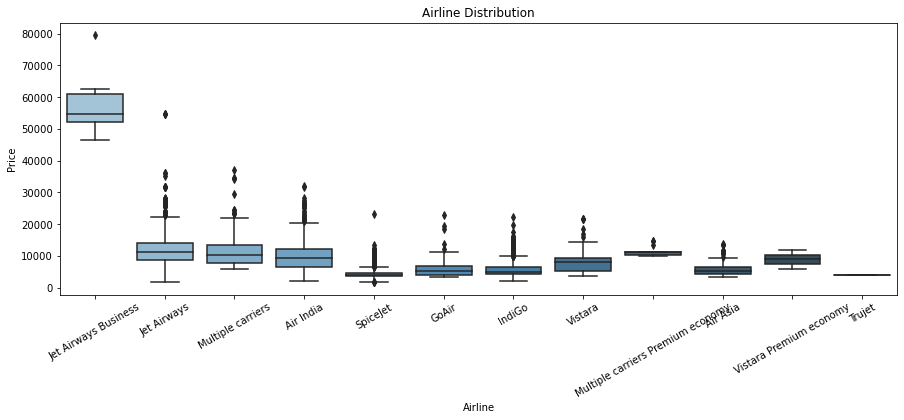

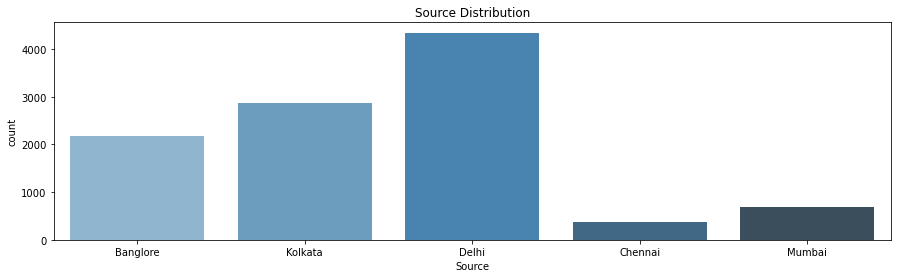

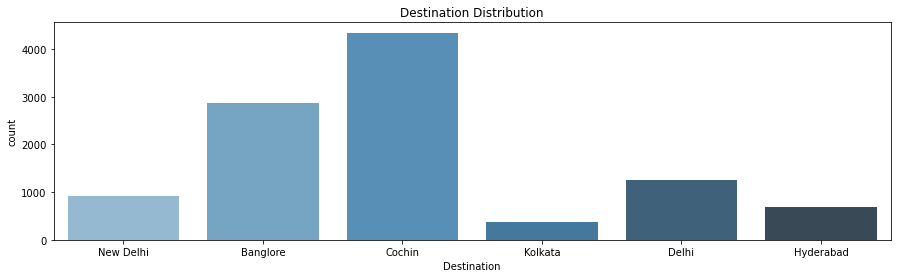

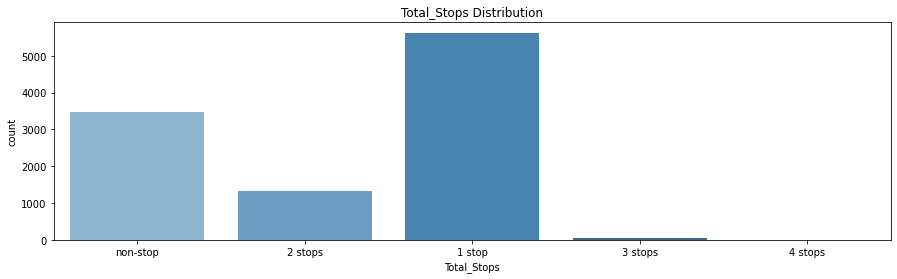

In [17]:
# Plotting Categories Data to get useful vision of data
for col in Categories:
    
    if col =='Airline':
        plt.figure(figsize=(15,5))
        ax=sns.boxplot(col,'Price' ,data=data.sort_values('Price',ascending = False),palette='Blues_d')
        ax.set_title(col+' Distribution')
        plt.xticks(rotation=30,fontsize=10)
        plt.show()
        
    elif (col !='Airline' and col !='Route'and col !='Additional_Info'):
        
        plt.figure(figsize=(15,4))
        ax=sns.countplot(col, data=data,palette='Blues_d')
        ax.set_title(col+' Distribution')
        plt.xticks(fontsize=10)
        plt.show()

In [18]:
# Dropping unusful columns
data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

In [19]:
# Relationships between Features
# sns.heatmap(data.corr(),annot=True,linewidths=0.2)
# fig=plt.gcf()
# fig.set_size_inches(12,8)
# plt.show()

### Preparing Data For Modeling

In [20]:
# dealing with Categorical Data

# Assign new value for each category in Total_Stops Column
data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)
# Covert Other Categories data with Label Encoder Technique
categorical = data.select_dtypes(include=['object'])
for col in categorical.columns:
    Encoder = LabelEncoder()
    Encoder.fit(data[col])
    data[col] = Encoder.transform(data[col])
# data=pd.get_dummies(data, drop_first = True)
# Display Data after Encoding
data.head()

,Airline,Source,Destination,Total_Stops,Price,Jrn_day,Jrn_month,Jrn_year,Dep_hr,Dep_min,Arv_hr,Arv_min,Dur_hr,Dur_min
0,3,0,5,0,3897,24,3,2019,22,20,1,10,2.0,50.0
1,1,3,0,2,7662,5,1,2019,5,50,13,15,7.0,25.0
2,4,2,1,2,13882,6,9,2019,9,25,4,25,19.0,0.0
3,3,3,0,1,6218,5,12,2019,18,5,23,30,5.0,25.0
4,3,0,5,1,13302,3,1,2019,16,50,21,35,4.0,45.0


In [21]:
#shape of data
data.shape

(10462, 14)

In [22]:
# Split Data into features and label
train=data.drop('Price',axis=1)
label = pd.DataFrame(data['Price'])

In [23]:
# Spliting data by using train_test_split technique
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size = 0.2, random_state = 42)

In [24]:
# Scaling Data with Normalization Technique
scaler_x = MinMaxScaler().fit(X_train)
scaler_y = MinMaxScaler().fit(y_train)
x_train_sc = scaler_x.transform(X_train)
x_test_sc = scaler_x.transform(X_test)
y_train_sc = scaler_y.transform(y_train)
y_test_sc = scaler_y.transform(y_test)

In [25]:
# Fit Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(x_train_sc, y_train_sc)
y_pred_sc = lr_model.predict(x_test_sc)
mae = mean_absolute_error(y_test_sc, y_pred_sc)
mse = mean_squared_error(y_test_sc, y_pred_sc)
rmse = np.sqrt(mean_squared_error(y_test_sc, y_pred_sc))

# Errors
print('MAE = ', mae.round(4))
print('MSE = ', mse.round(4))
print('RMSE = ', rmse.round(4))

MAE =  0.0319
MSE =  0.002
RMSE =  0.0442


In [29]:
# Inverse Scaler to get original data
y_test_inv = scaler_y.inverse_transform(y_test_sc.reshape(-1,1))
y_pred_inv = scaler_y.inverse_transform(y_pred_sc.reshape(-1,1))

actual_mae = mean_absolute_error(y_test_inv, y_pred_inv)
actual_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print('Actual MAE = ', int(actual_mae))
print('Actual RMSE = ', int(actual_rmse))

Actual MAE =  2480
Actual RMSE =  3440


In [27]:
# Fit Random Forest Regrissor Model
RF_Model = RandomForestRegressor(n_estimators=900,min_samples_split=12,max_depth=20)
RF_Model.fit(X_train, y_train)
Predictions = RF_Model.predict(X_test)
print('Train Acc: ',round(RF_Model.score(X_train, y_train)*100,2))
print('Test Acc : ',round(RF_Model.score(X_test, y_test)*100,2))
print('R2_Score :', round(metrics.r2_score(y_test, Predictions)*100,2))

Train Acc:  89.07
Test Acc :  81.01
R2_Score : 81.01
